# Отток клиентов

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#upsampling" data-toc-modified-id="upsampling-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>upsampling</a></span></li><li><span><a href="#downsampling" data-toc-modified-id="downsampling-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>downsampling</a></span></li><li><span><a href="#balanced" data-toc-modified-id="balanced-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>balanced</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

## Описание проекта

Из банка каждый месяц стали уходить клиенты. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Цель проекта — спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

В ходе проекта мы должны построить модель с предельно большим значением *F1*-меры — не менее 0.59 на тестовой выборке.

Дополнительно будем измерять *AUC-ROC*, сравнивая её значение с *F1*-мерой.

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

## Подготовка данных

Начнем с того, что загрузим данные и подготовим их к обучению модели.

In [2]:
try:
    df = pd.read_csv('Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [5]:
len(df[df['Tenure'].isna()]['Tenure'])

909

Как видим, пропуски присутствуют только в столбце Tenure. Причем их количество примерно равно числу значений в каждой из категорий. Если бы мы могли обратиться к сотрудникам банка, мы бы уточнили природу этих пропусков, но, так как такой возможности нет, попробуем предположить следующее:

Учитывая, что тех клиентов, у которых в данном столбце стоит значение 0, всего 382 (что в 3 раза меньше остальных, хотя наверняка отсутствие недвижимости не такая редкая ситуация), значения NaN могут относиться именно к этой категории. Попробуем заменить пропущенные значения на 0, а тип столбца привести к int.

In [6]:
df['Tenure'] = df['Tenure'].fillna(0).astype('int')

Далее, заменим категориальные столбцы Gender и Geography на дамми-признаки. При этом уберем первый столбец из получившихся, чтобы не попасть в дамми-ловушку.

In [7]:
df['isMale'] = pd.get_dummies(df['Gender'], drop_first=True)

In [8]:
df[['Germany', 'Spain']] = pd.get_dummies(df['Geography'], drop_first=True)

Теперь можно убрать ненужные нам столбцы, которые не несут ценной информации, либо были заменены.

In [9]:
df = df.drop(['RowNumber', 'Surname', 'CustomerId', 'Gender', 'Geography'], axis=1)

In [10]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,isMale,Germany,Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1


Разделим данные на целевой признак и фичи.

In [11]:
target = df['Exited']
features = df.drop('Exited', axis=1)

Итак, мы провели подготовку данных для обучения модели, которая включила в себя заполнение пропусков, преобразование категориальных признаков, разделение набора на целевой признак и фичи. Далее мы приступим к обучению и посмотрим, какая из известных нам моделей справляется с представленными данными лучше всего.

## Исследование задачи

Так как в настоящем проекте мы имеем дело с задачей классификации, нам стоит проверить баланс предсказываемых классов, чтобы настроить модель и выборки соответствующим образом.

Соотношение 0 к 1: 3.9091801669121256


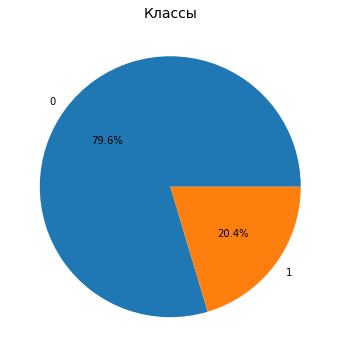

In [12]:
pie, ax = plt.subplots(figsize=[10,6])
labels = ['0', '1']
plt.pie(x=df.groupby('Exited')['Exited'].count(), labels=labels, autopct="%.1f%%")
plt.title("Классы", fontsize=14);
print('Соотношение 0 к 1:', target.value_counts()[0] / target.value_counts()[1])

Наша выборка имеет дисбаланс классов — нулей в целевом признаке в четыре раза больше, чем единиц. В дальнейшем нам потребуется учесть этот факт и использовать инструменты по борьбе с дисбалансом — это поможет повысить качество обучения, — но для начала попробуем посмотреть, как модели справляются с несбалансированной выборкой.

Разделим полученные фичи на обучающую и валидационную выборку.

In [13]:
features_train, features_valid, target_train, target_valid = train_test_split(
                                        features, target, test_size=0.25, random_state=12345)

print('Размеры обучающей выборки:', features_train.shape)
print('Размеры валидационной выборки:', features_valid.shape)

Размеры обучающей выборки: (7500, 11)
Размеры валидационной выборки: (2500, 11)


Поскольку наши признаки имеют разный масштаб, необходимо произвести стандартизацию, чтобы привести их к одинаковому распределению.

In [14]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)

Далее проверим работу трех алгоритмов на полученных выборках — логистической регресии, решающего дерева и случайного леса. Поскольку при дисбалансе метрика Accuracy не будет показательной, мы будем использовать метрику F1. Она позволит нам посмотреть, насколько хорошо модели определяют положительный класс. Одновременно с этим будем проверять метрику ROC AUC, чтобы проверить, насколько хорошо модель в целом определяет вероятности классов.

In [15]:
# логистическая регрессия
best_logreg_f1 = 0
best_logreg_rocauc = 0
best_logreg = None
for reg in [0.01, 0.1, 1]:
    logreg = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1', C=reg)
    logreg.fit(features_train_scaled, target_train)
    logreg_prediction = logreg.predict(features_valid_scaled)
    logreg_predprob = logreg.predict_proba(features_valid_scaled)
    logreg_f1 = f1_score(target_valid, logreg_prediction)
    logreg_rocauc = roc_auc_score(target_valid, logreg_predprob[:, 1])
    if logreg_f1 > best_logreg_f1:
        best_logreg_f1 = logreg_f1
        best_logreg = logreg # здесь хранится лучшая модель
        best_logreg_rocauc = logreg_rocauc
        
print('Лучшая модель:', best_logreg)
print('Лучший F1:', best_logreg_f1)
print('Лучший ROC AUC:', best_logreg_rocauc)

Лучшая модель: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)
Лучший F1: 0.2932960893854748
Лучший ROC AUC: 0.7586159663266033


In [16]:
# случайное дерево
best_tree_f1 = 0
best_tree_rocauc = 0
best_tree = None
for depth in range(1,16):
    tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    tree.fit(features_train_scaled, target_train) # обучаем модель
    tree_prediction = tree.predict(features_valid_scaled) # предсказываем значения валидационной выборки
    tree_predprob = tree.predict_proba(features_valid_scaled)
    tree_f1 = f1_score(target_valid, tree_prediction)
    tree_rocauc = roc_auc_score(target_valid, tree_predprob[:, 1])
    if tree_f1 > best_tree_f1:
        best_tree_f1 = tree_f1
        best_tree = tree # здесь хранится лучшая модель
        best_tree_rocauc = tree_rocauc
        
print('Лучшая модель:', best_tree)
print('Лучший F1:', best_tree_f1)
print('Лучший ROC AUC:', best_tree_rocauc)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Лучшая модель: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')
Лучший F1: 0.5704545454545454
Лучший ROC AUC: 0.8424341870585718


In [17]:
# решающий лес
best_forest_f1 = 0
best_forest_rocauc = 0
best_forest = None
for depth in range(1,16):
    for n_est in range(1,50,5):
        forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_est)
        forest.fit(features_train_scaled, target_train) # обучаем модель
        forest_prediction = forest.predict(features_valid_scaled) # предсказываем значения валидационной выборки
        forest_predprob = forest.predict_proba(features_valid_scaled)
        forest_f1 = f1_score(target_valid, forest_prediction)
        forest_rocauc = roc_auc_score(target_valid, forest_predprob[:, 1])
        if forest_f1 > best_forest_f1:
            best_forest_f1 = forest_f1
            best_forest = forest # здесь хранится лучшая модель
            best_forest_rocauc = forest_rocauc
        
print('Лучшая модель:', best_forest)
print('Лучший F1:', best_forest_f1)
print('Лучший ROC AUC:', best_forest_rocauc)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

Лучшая модель: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=26,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
Лучший F1: 0.5748502994011976
Лучший ROC AUC: 0.8501158117523959


Как видим, лучший результат по двум метрикам показал случайный лес, но и решающее дерево справилось не намного хуже. Самый маленький показатель был получен у логиcтичекой регресии, но при этом ROC AUC всё равно выше, чем у случайной модели (0,75 по сравнению с 0,5). 

Тем не менее, целевого показателя F1 в 0,59 мы не достигли. Низкий показатель F1 может быть связан с тем, что в обучающей выборке вообще не попалось положительного класса, и модель не смогла обучиться, либо попался, но в разных пропорциях с валидационной выборкой.

Попробуем провести корректировку дисбаланса классов и проверить, как справятся модели на этот раз.

## Борьба с дисбалансом

В этом шаге мы постараемся улучшить качество моделей, учитывая дисбаланс классов. Попробуем обучить те же модели, но применим три разных способа борьбы с дисбалансом — upsampling, downsampling и взвешивание.

В этот раз будем делить данные на три выборки — обучающая, валидационная и тестовая. Их пропорции — 60/20/20. При разбиении также будем учитывать дисбаланс классов и установим параметр stratify, чтобы во всех выборках оказалось одинаковое распределение классов.

In [18]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.40, random_state=12345, stratify=target)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid_test, target_valid_test, test_size=0.50, random_state=12345, stratify=target_valid_test)

print('Размеры обучающей выборки:', features_train.shape)
print('Размеры валидационной выборки:', features_valid.shape)
print('Размеры тестовой выборки:', features_test.shape)

Размеры обучающей выборки: (6000, 11)
Размеры валидационной выборки: (2000, 11)
Размеры тестовой выборки: (2000, 11)


### upsampling

Начнем борьбу с дисбалансом с метода upsampling и в 4 раза увеличим количество представителей положительного класса в обучающей выборке.

In [19]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Не забудем масштабировать признаки.

In [20]:
scaler.fit(features_upsampled)
features_up_train_scaled = scaler.transform(features_upsampled)
features_up_valid_scaled = scaler.transform(features_valid)
features_up_test_scaled = scaler.transform(features_test)

На полученной обучающей выборке обучим модели и проверим результат обучения на валидационной выборке.

In [21]:
best_logreg_f1 = 0
best_logreg_rocauc = 0
best_logreg_up = None
for reg in [0.01, 0.1, 1]:
    logreg = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1', C=reg)
    logreg.fit(features_up_train_scaled, target_upsampled)
    logreg_prediction = logreg.predict(features_up_valid_scaled)
    logreg_predprob = logreg.predict_proba(features_up_valid_scaled)
    logreg_f1 = f1_score(target_valid, logreg_prediction)
    logreg_rocauc = roc_auc_score(target_valid, logreg_predprob[:, 1])
    if logreg_f1 > best_logreg_f1:
        best_logreg_f1 = logreg_f1
        best_logreg_up = logreg # здесь хранится лучшая модель
        best_logreg_rocauc = logreg_rocauc
        
print('Лучшая модель:', best_logreg_up)
print('Лучший F1:', best_logreg_f1)
print('Лучший ROC AUC:', best_logreg_rocauc)

Лучшая модель: LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)
Лучший F1: 0.48226950354609927
Лучший ROC AUC: 0.7563434004111971


In [22]:
best_tree_f1 = 0
best_tree_rocauc = 0
best_tree_up = None
for depth in range(1,16):
    tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    tree.fit(features_up_train_scaled, target_upsampled) # обучаем модель
    tree_prediction = tree.predict(features_up_valid_scaled) # предсказываем значения валидационной выборки
    tree_predprob = tree.predict_proba(features_up_valid_scaled)
    tree_f1 = f1_score(target_valid, tree_prediction)
    tree_rocauc = roc_auc_score(target_valid, tree_predprob[:, 1])
    if tree_f1 > best_tree_f1:
        best_tree_f1 = tree_f1
        best_tree_up = tree # здесь хранится лучшая модель
        best_tree_rocauc = tree_rocauc
        
print('Лучшая модель:', best_tree_up)
print('Лучший F1:', best_tree_f1)
print('Лучший ROC AUC:', best_tree_rocauc)

Лучшая модель: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')
Лучший F1: 0.5452881976212259
Лучший ROC AUC: 0.7903049428473157


In [23]:
best_forest_f1 = 0
best_forest_rocauc = 0
best_forest_up = None
for depth in range(1,16):
    for n_est in range(1,50,5):
        forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_est)
        forest.fit(features_up_train_scaled, target_upsampled) # обучаем модель
        forest_prediction = forest.predict(features_up_valid_scaled) # предсказываем значения валидационной выборки
        forest_predprob = forest.predict_proba(features_up_valid_scaled)
        forest_f1 = f1_score(target_valid, forest_prediction)
        forest_rocauc = roc_auc_score(target_valid, forest_predprob[:, 1])
        if forest_f1 > best_forest_f1:
            best_forest_f1 = forest_f1
            best_forest_up = forest # здесь хранится лучшая модель
            best_forest_rocauc = forest_rocauc
        
print('Лучшая модель:', best_forest_up)
print('Лучший F1:', best_forest_f1)
print('Лучший ROC AUC:', best_forest_rocauc)

Лучшая модель: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=41,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
Лучший F1: 0.6063720452209661
Лучший ROC AUC: 0.8542687525738373


Качество метрики F1 заметно улучшилось для логистической регресии, немного поднялось для случайного леса, превысив целевой показатель, но упало для решающего дерева. На метрику ROC AUC метод повлиял не сильно.

### downsampling

Далее перейдем к методу downsampling. Уменьшим в четыре раза количество строчек отрицательного класса в обучающей выборке.

In [24]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [25]:
scaler.fit(features_downsampled)
features_down_train_scaled = scaler.transform(features_downsampled)
features_down_valid_scaled = scaler.transform(features_valid)
features_down_test_scaled = scaler.transform(features_test)

In [26]:
best_logreg_f1 = 0
best_logreg_rocauc = 0
best_logreg_down = None
for reg in [0.01, 0.1, 1]:
    logreg = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1', C=reg)
    logreg.fit(features_down_train_scaled, target_downsampled)
    logreg_prediction = logreg.predict(features_down_valid_scaled)
    logreg_predprob = logreg.predict_proba(features_down_valid_scaled)
    logreg_f1 = f1_score(target_valid, logreg_prediction)
    logreg_rocauc = roc_auc_score(target_valid, logreg_predprob[:, 1])
    if logreg_f1 > best_logreg_f1:
        best_logreg_f1 = logreg_f1
        best_logreg_down = logreg # здесь хранится лучшая модель
        best_logreg_rocauc = logreg_rocauc
        
print('Лучшая модель:', best_logreg_down)
print('Лучший F1:', best_logreg_f1)
print('Лучший ROC AUC:', best_logreg_rocauc)

Лучшая модель: LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)
Лучший F1: 0.4963768115942029
Лучший ROC AUC: 0.7578803765244443


In [27]:
best_tree_f1 = 0
best_tree_rocauc = 0
best_tree_down = None
for depth in range(1,16):
    tree = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    tree.fit(features_down_train_scaled, target_downsampled) # обучаем модель
    tree_prediction = tree.predict(features_down_valid_scaled) # предсказываем значения валидационной выборки
    tree_predprob = tree.predict_proba(features_down_valid_scaled)
    tree_f1 = f1_score(target_valid, tree_prediction)
    tree_rocauc = roc_auc_score(target_valid, tree_predprob[:, 1])
    if tree_f1 > best_tree_f1:
        best_tree_f1 = tree_f1
        best_tree_down = tree # здесь хранится лучшая модель
        best_tree_rocauc = tree_rocauc
        
print('Лучшая модель:', best_tree_down)
print('Лучший F1:', best_tree_f1)
print('Лучший ROC AUC:', best_tree_rocauc)

Лучшая модель: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')
Лучший F1: 0.5604606525911707
Лучший ROC AUC: 0.8213483128737367


In [28]:
best_forest_f1 = 0
best_forest_rocauc = 0
best_forest_down = None
for depth in range(1,16):
    for n_est in range(1,50,5):
        forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_est)
        forest.fit(features_down_train_scaled, target_downsampled) # обучаем модель
        forest_prediction = forest.predict(features_down_valid_scaled) # предсказываем значения валидационной выборки
        forest_predprob = forest.predict_proba(features_down_valid_scaled)
        forest_f1 = f1_score(target_valid, forest_prediction)
        forest_rocauc = roc_auc_score(target_valid, forest_predprob[:, 1])
        if forest_f1 > best_forest_f1:
            best_forest_f1 = forest_f1
            best_forest_down = forest # здесь хранится лучшая модель
            best_forest_rocauc = forest_rocauc
        
print('Лучшая модель:', best_forest_down)
print('Лучший F1:', best_forest_f1)
print('Лучший ROC AUC:', best_forest_rocauc)

Лучшая модель: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=21,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
Лучший F1: 0.5913875598086125
Лучший ROC AUC: 0.8444715902343022


Использование метода downsampling привело к увеличению результата F1 по сравнению с несбалансированной выборкой для всех моделей. Также чуть улучшился результат регрессии и дерева по сравнению с upsampling. Однако результаты для леса всё равно получились чуть ниже, чем при использовании upsampling. Вероятно, это связано с тем, что лесу требуется большее количество данных для более качественного обучения.

### balanced

Последний метод борьбы с диасбалансом классов, что мы проверим — взвешивание классов. В каждой модели мы поставим параметр class_weight со значением balanced, чтобы модели определяли вес классов, исходя из их пропорций.

In [29]:
scaler.fit(features_train)
features_balanced_train_scaled = scaler.transform(features_train)
features_balanced_valid_scaled = scaler.transform(features_valid)
features_balanced_test_scaled = scaler.transform(features_test)

In [30]:
best_logreg_f1 = 0
best_logreg_rocauc = 0
best_logreg_balanced = None
for reg in [0.01, 0.1, 1]:
    logreg = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1', C=reg, class_weight='balanced')
    logreg.fit(features_balanced_train_scaled, target_train)
    logreg_prediction = logreg.predict(features_balanced_valid_scaled)
    logreg_predprob = logreg.predict_proba(features_balanced_valid_scaled)
    logreg_f1 = f1_score(target_valid, logreg_prediction)
    logreg_rocauc = roc_auc_score(target_valid, logreg_predprob[:, 1])
    if logreg_f1 > best_logreg_f1:
        best_logreg_f1 = logreg_f1
        best_logreg_balanced = logreg # здесь хранится лучшая модель
        best_logreg_rocauc = logreg_rocauc
        
print('Лучшая модель:', best_logreg_balanced)
print('Лучший F1:', best_logreg_f1)
print('Лучший ROC AUC:', best_logreg_rocauc)

Лучшая модель: LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)
Лучший F1: 0.4777594728171334
Лучший ROC AUC: 0.7575132914115965


In [31]:
best_tree_f1 = 0
best_tree_rocauc = 0
best_tree_balanced = None
for depth in range(1,16):
    tree = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    tree.fit(features_balanced_train_scaled, target_train) # обучаем модель
    tree_prediction = tree.predict(features_balanced_valid_scaled) # предсказываем значения валидационной выборки
    tree_predprob = tree.predict_proba(features_balanced_valid_scaled)
    tree_f1 = f1_score(target_valid, tree_prediction)
    tree_rocauc = roc_auc_score(target_valid, tree_predprob[:, 1])
    if tree_f1 > best_tree_f1:
        best_tree_f1 = tree_f1
        best_tree_balanced = tree # здесь хранится лучшая модель
        best_tree_rocauc = tree_rocauc
        
print('Лучшая модель:', best_tree_balanced)
print('Лучший F1:', best_tree_f1)
print('Лучший ROC AUC:', best_tree_rocauc)

Лучшая модель: DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')
Лучший F1: 0.5452881976212259
Лучший ROC AUC: 0.7903049428473157


In [32]:
best_forest_f1 = 0
best_forest_rocauc = 0
best_forest_balanced = None
for depth in range(1,16):
    for n_est in range(1,50,5):
        forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=n_est, class_weight='balanced')
        forest.fit(features_balanced_train_scaled, target_train) # обучаем модель
        forest_prediction = forest.predict(features_balanced_valid_scaled) # предсказываем значения валидационной выборки
        forest_predprob = forest.predict_proba(features_balanced_valid_scaled)
        forest_f1 = f1_score(target_valid, forest_prediction)
        forest_rocauc = roc_auc_score(target_valid, forest_predprob[:, 1])
        if forest_f1 > best_forest_f1:
            best_forest_f1 = forest_f1
            best_forest_balanced = forest # здесь хранится лучшая модель
            best_forest_rocauc = forest_rocauc
        
print('Лучшая модель:', best_forest_balanced)
print('Лучший F1:', best_forest_f1)
print('Лучший ROC AUC:', best_forest_rocauc)

Лучшая модель: RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=16, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)
Лучший F1: 0.6075949367088608
Лучший ROC AUC: 0.8438685218346235


Этот метод также позволил повысить качество каждой из моделей по сравнению с обучением на несбалансированных выборках.

Проведенное исследование методов борьбы с дисбалансом классов показало, что такие методы действительно помогают повысить качество предсказаний моделей, но для каждой модели методы работают по-разному. В нашем случае для регрессии и дерева лучше всего сработал метод downsampling. Для леса же этот метод оказался чуть менее эффективным, зато другие два позволили получить примерно одинаково высокие результаты. 

## Тестирование модели

Поскольку нашей целью является получение на тестовой выборке F1 не ниже 0,59, мы будем использовать модель, которая в каждом из испытаний справилась лучше всего — это случайный лес. Проверим лес, обученный с помощью разных методов борьбы с дисбалансом, и посмотрим, какой справляется лучше всего.

In [33]:
# upsampled
forest_up_prediction_test = best_forest_up.predict(features_up_test_scaled)
forest_up_predprob_test = best_forest_up.predict_proba(features_up_test_scaled)
forest_test_f1 = f1_score(target_test, forest_up_prediction_test)
forest_test_rocauc = roc_auc_score(target_test, forest_up_predprob_test[:, 1])

print('F1:', forest_test_f1)
print('ROC AUC:', forest_test_rocauc)

F1: 0.6283987915407855
ROC AUC: 0.8692174105823234


In [34]:
# downsampled
forest_down_prediction_test = best_forest_down.predict(features_down_test_scaled)
forest_down_predprob_test = best_forest_down.predict_proba(features_down_test_scaled)
forest_test_f1 = f1_score(target_test, forest_down_prediction_test)
forest_test_rocauc = roc_auc_score(target_test, forest_down_predprob_test[:, 1])

print('F1:', forest_test_f1)
print('ROC AUC:', forest_test_rocauc)

F1: 0.6096866096866097
ROC AUC: 0.8553059414720662


In [35]:
# balanced
forest_balanced_prediction_test = best_forest_balanced.predict(features_balanced_test_scaled)
forest_balanced_predprob_test = best_forest_balanced.predict_proba(features_balanced_test_scaled)
forest_test_f1 = f1_score(target_test, forest_balanced_prediction_test)
forest_test_rocauc = roc_auc_score(target_test, forest_balanced_predprob_test[:, 1])

print('F1:', forest_test_f1)
print('ROC AUC:', forest_test_rocauc)

F1: 0.6288888888888889
ROC AUC: 0.856822408611686


Итак, все модели примерно одинаково справились с предсказаниями, каждая превысив показатель F1 в 0,59. Чуть лучше других справилась модель, обученная по методу взвешивания классов. ROC AUC во всех случаях превышает значение в 85.